In [1]:
# numerical analysis
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.stats import norm


# visualization
import seaborn as sns
import matplotlib.pyplot as plt

#  model selection & metrics
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import RocCurveDisplay, auc, classification_report, roc_auc_score, mean_absolute_error


# pipelines
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from category_encoders import TargetEncoder, MEstimateEncoder
from sklearn.impute import SimpleImputer

# dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
# clusters
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# rigression models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# models Analysis and Explainability 
from eli5.sklearn import PermutationImportance
import eli5
from sklearn.inspection import PartialDependenceDisplay
import shap


# utitlity
from copy import deepcopy
from path import Path
import warnings 
warnings.filterwarnings('ignore') # supress warnings

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

In [2]:
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [3]:
# metric evaluation function from https://www.kaggle.com/code/datafan07/icr-simple-eda-baseline/notebook#Baseline-Model
 
def balance_logloss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    y_pred / np.sum(y_pred, axis=1)[:, None]
    nc = np.bincount(y_true)
    
    logloss = (-1/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(y_pred[:,0]))) - 1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred[:,1])))) / 2
    
    return logloss

In [4]:
oof_preds = np.zeros(560 * 3 * 2).reshape(3, 560, 2)
oof_preds[0][0]

array([0., 0.])

In [5]:
# a function which would evaluate model given dataset and model pipeline
def evaluate_model(model_name, model_pipeline, _X, _y, split_sr, n_splits=5, random_state_list=[0, 5, 10], verbose=True):
    len_y = len(_y)
    len_states = len(random_state_list)

    oof_preds = np.zeros(len_y * len_states * 2).reshape(len_states, len_y, 2)
    models_pipeline = []
    scores_train = []
    scores_val = []
    train_means = []
    val_means = []

    
    for index, random_state in enumerate(random_state_list):
        if verbose:
            print("#"*25)
            print("#"*15, f"traininng model {model_name} with seed {random_state}")
            print("#"*25)
            
        splitter = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
        splits = 0
        for train_idx, val_idx in splitter.split(_X, split_sr):
            X_train, y_train = _X.iloc[train_idx], _y.iloc[train_idx]
            X_val, y_val = _X.iloc[val_idx], _y.iloc[val_idx]
            
#         fitting model
            model_pipeline.fit(X_train, y_train)
#         making predictions for train and validation set
            train_preds = model_pipeline.predict_proba(X_train)
            val_preds = model_pipeline.predict_proba(X_val)
        
#         storing validation preds for future use
            oof_preds[index, val_idx, 0] = val_preds[:, 0]
            oof_preds[index, val_idx, 1] = val_preds[:, 1]
    
#         train and validation score in each split 
            score_train = balance_logloss(y_train, train_preds)
            score_val = balance_logloss(y_val, val_preds)
            
            models_pipeline.append(deepcopy(model_pipeline))
            
            scores_train.append(score_train)
            scores_val.append(score_val)

            splits += 1
            if verbose:
                print(f"seed {random_state} and split {splits} balanced log loss {score_val}")

          
    oof_preds_mean = oof_preds
    mean_train_score = np.mean(scores_train)
    mean_val_score = np.mean(scores_val)
    cv_gap = mean_train_score - mean_val_score
    val_std = np.std(scores_val)
    
    print()
    print(f'{model_name} Average balanced log loss : {np.mean(scores_val)}')

    return models_pipeline, oof_preds_mean, mean_train_score, mean_val_score, cv_gap, val_std

In [6]:
# loading datasets
path = Path("/kaggle/input/icr-identify-age-related-conditions/")

train = pd.read_csv(path / "train.csv")
test = pd.read_csv(path / "test.csv")
greeks = pd.read_csv(path / "greeks.csv")
                     
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()
    
display(train.head())
display(greeks.head())

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [7]:
train_temp = train.copy()

# encoding EJ
cat_cols = 'EJ'
encoder = LabelEncoder()
train_temp[cat_cols] = encoder.fit_transform(train_temp[[cat_cols]])
test[cat_cols] = encoder.transform(test[cat_cols])

X = train_temp.drop(['Class', 'Id'], axis=1)
y = train_temp['Class']
split_sr = y
feats = X.columns.tolist()

In [8]:
%%time
n_splits= 100
random_states = [0, 5]

classifiers = {
    "lr": LogisticRegression(random_state=0),
    "lda": LDA(),
    "gb": GradientBoostingClassifier(random_state=0),
    "svc": SVC(probability=True, random_state=0),
    "knn": KNeighborsClassifier(),
    'hist': HistGradientBoostingClassifier(random_state=0),
    "rf": RandomForestClassifier(random_state=0),
    "ada": AdaBoostClassifier(random_state=0),
    "extra": ExtraTreesClassifier(random_state=0),
    'lgbm': LGBMClassifier(random_state=0),
    "xgb": XGBClassifier(random_state=0),
    "cat": CatBoostClassifier(silent=True, random_state=0)
}

scores_log = pd.DataFrame(columns=['model_name', 'no_of_fold', 'train_error', "valid_error", "cv_gap", "std"],
                          index=range(len(classifiers)*5))
index = 0


for model_name, model in classifiers.items():


    model_pipe = make_pipeline(SimpleImputer(strategy="median"), MinMaxScaler(), model)
    models, oof, tr_loss, oof_val_loss, cv_gap, loss_std = evaluate_model(model_name, model_pipe, X, y, split_sr, 
                                                   n_splits=n_splits, random_state_list=random_states, verbose=True)
    
    
    scores_log.loc[index] = [model_name, 100, tr_loss, oof_val_loss, cv_gap, loss_std]
    index += 1

#########################
############### traininng model lr with seed 0
#########################
seed 0 and split 1 balanced log loss 0.8973211929058516
seed 0 and split 2 balanced log loss 0.3576784519245115
seed 0 and split 3 balanced log loss 0.9256966294237212
seed 0 and split 4 balanced log loss 0.5622240241540721
seed 0 and split 5 balanced log loss 0.25800580761338715
seed 0 and split 6 balanced log loss 0.549711311548249
seed 0 and split 7 balanced log loss 0.5615824299378858
seed 0 and split 8 balanced log loss 0.6797238592167684
seed 0 and split 9 balanced log loss 0.7016282121806934
seed 0 and split 10 balanced log loss 0.353204313686456
seed 0 and split 11 balanced log loss 0.09257601433502444
seed 0 and split 12 balanced log loss 0.9321407322645753
seed 0 and split 13 balanced log loss 0.9265666045472671
seed 0 and split 14 balanced log loss 0.6881355632911325
seed 0 and split 15 balanced log loss 0.2868987324726302
seed 0 and split 16 balanced log loss 0.766919527370514

In [9]:
scores_log.head(5)

,model_name,no_of_fold,train_error,valid_error,cv_gap,std
0,lr,100,0.591881,0.684214,-0.092333,0.462967
1,lda,100,0.456121,0.768197,-0.312076,1.032177
2,gb,100,0.031912,0.447445,-0.415533,0.589445
3,svc,100,0.413511,0.535195,-0.121683,0.482661
4,knn,100,0.480952,4.271805,-3.790853,6.796838


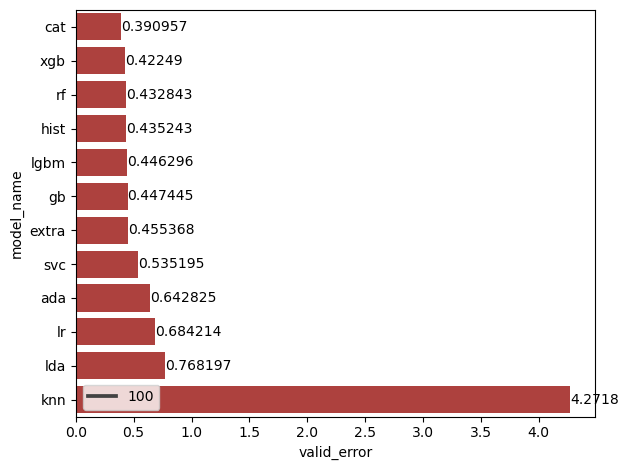

In [10]:
data = scores_log.sort_values(by='valid_error')
ax = sns.barplot(data=data, x='valid_error', y='model_name', color='#C0302B')
ax.bar_label(ax.containers[0])
ax.legend([n_splits], loc='lower left')

plt.tight_layout()

In [11]:
model = make_pipeline(SimpleImputer(strategy="median"), MinMaxScaler(), CatBoostClassifier(silent=True, random_state=0))
model.fit(X, y)
preds = model.predict_proba(test[feats])

In [12]:
sample_submission = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
sample_submission['class_0'] = preds[:, 0]
sample_submission['class_1'] = preds[:, 1]
sample_submission.to_csv('submission.csv',index=False)
sample_submission

,Id,class_0,class_1
0,00eed32682bb,0.814333,0.185667
1,010ebe33f668,0.814333,0.185667
2,02fa521e1838,0.814333,0.185667
3,040e15f562a2,0.814333,0.185667
4,046e85c7cc7f,0.814333,0.185667
